<a href="https://colab.research.google.com/github/cryptasim/MACHINE-LEARNING-LAB/blob/main/ASSIGNMENT%203/Assignment3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries

In [1]:
!pip install -q tensorflow seaborn scikit-learn matplotlib tqdm pandas

### Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Check TensorFlow and GPU

In [3]:
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Helper functions for plotting and evaluation

In [4]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(title+" Accuracy"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title+" Loss"); plt.legend()
    plt.show()

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

def plot_roc(y_true_onehot, y_pred_prob, title):
    plt.figure(figsize=(6,5))
    for i in range(y_true_onehot.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_onehot[:,i], y_pred_prob[:,i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{title} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def macro_auc(y_true_onehot, y_pred_prob):
    fpr,tpr,roc_auc={},{},{}
    for i in range(y_true_onehot.shape[1]):
        fpr[i],tpr[i],_ = roc_curve(y_true_onehot[:,i], y_pred_prob[:,i])
        roc_auc[i]=auc(fpr[i],tpr[i])
    return np.mean(list(roc_auc.values()))

### Load and preprocess data

In [5]:
(m_x_train, m_y_train),(m_x_test, m_y_test)=keras.datasets.mnist.load_data()
m_x_all = np.concatenate([m_x_train, m_x_test]).astype('float32')/255.0
m_x_all = np.expand_dims(m_x_all,-1)
m_y_all = np.concatenate([m_y_train, m_y_test])
m_y_all_cat = to_categorical(m_y_all,10)
m_x_all_vgg = tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(m_x_all)),[32,32]).numpy()

# CIFAR-10
(c_x_train,c_y_train),(c_x_test,c_y_test)=keras.datasets.cifar10.load_data()
c_x_all = np.concatenate([c_x_train,c_x_test]).astype('float32')/255.0
c_y_all = np.concatenate([c_y_train,c_y_test]).flatten()
c_y_all_cat = to_categorical(c_y_all,10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


### Model Building Functions

In [6]:
def build_cnn(input_shape,n_classes):
    model=models.Sequential([
        layers.Conv2D(32,3,activation='relu',padding='same',input_shape=input_shape),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_vgg16(input_shape,n_classes):
    base=VGG16(include_top=False,weights=None,input_shape=input_shape)
    x=layers.Flatten()(base.output)
    x=layers.Dense(256,activation='relu')(x)
    out=layers.Dense(n_classes,activation='softmax')(x)
    model=models.Model(base.input,out)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_alexnet_small(input_shape,n_classes):
    model=models.Sequential([
        layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_googlenet_small(input_shape,n_classes):
    inp=layers.Input(shape=input_shape)
    x=layers.Conv2D(64,3,activation='relu',padding='same')(inp)
    x=layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(2)(x)
    x=layers.Conv2D(256,3,activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(2)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(512,activation='relu')(x)
    out=layers.Dense(n_classes,activation='softmax')(x)
    model=models.Model(inp,out)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_rnn(input_shape,n_classes):
    model=models.Sequential([
        layers.Input(shape=(input_shape[0],input_shape[1])),
        layers.LSTM(128),
        layers.Dense(128,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

### Training and Evaluation

In [7]:
def train_and_eval(model,X_train,y_train,X_test,y_test,y_test_cat,name,dataset,split_ratio):
    hist=model.fit(X_train,y_train,validation_split=0.1,epochs=5,batch_size=128,verbose=2)
    eval_res=model.evaluate(X_test,y_test_cat,verbose=0)
    preds=model.predict(X_test)
    pred_labels=np.argmax(preds,axis=1)
    rocA=macro_auc(y_test_cat,preds)
    report=classification_report(y_test,pred_labels,output_dict=True,zero_division=0)
    acc,prec,rec,f1=eval_res[1],report['weighted avg']['precision'],report['weighted avg']['recall'],report['weighted avg']['f1-score']
    return {"Dataset":dataset,"Model":name,"Split":split_ratio,"Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"AUC":rocA,"History":hist,"Y_true":y_test,"Y_pred":preds}

### initialization of results and splits

In [8]:
results=[]
splits = [0.6,0.7,0.8]

### MNIST Model Training

In [9]:
mnist_models=[
    ("CNN", build_cnn((28,28,1),10)),
    ("VGG16", build_vgg16((32,32,3),10)),
    ("AlexNet", build_alexnet_small((32,32,3),10)),
    ("GoogLeNet", build_googlenet_small((32,32,3),10)),
    ("RNN", build_rnn((28,28),10))
]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(m_x_all, m_y_all, train_size=split, random_state=42, stratify=m_y_all)
    X_train_cat, X_test_cat = to_categorical(y_train,10), to_categorical(y_test,10)
    X_train_vgg, X_test_vgg = tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train)),[32,32]).numpy(), \
                               tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test)),[32,32]).numpy()

    for name, model in mnist_models:
        if name in ["VGG16","AlexNet","GoogLeNet"]:
            res=train_and_eval(model,X_train_vgg,X_train_cat,X_test_vgg,y_test,X_test_cat,name,"MNIST",split)
        elif name=="RNN":
            res=train_and_eval(model,X_train[:,:,0],X_train_cat,X_test[:,:,0],y_test,X_test_cat,name,"MNIST",split)
        else:
            res=train_and_eval(model,X_train,X_train_cat,X_test,y_test,X_test_cat,name,"MNIST",split)
        results.append(res)

Epoch 1/5
296/296 - 10s - 34ms/step - accuracy: 0.9288 - loss: 0.2368 - val_accuracy: 0.9805 - val_loss: 0.0651
Epoch 2/5
296/296 - 2s - 7ms/step - accuracy: 0.9842 - loss: 0.0528 - val_accuracy: 0.9783 - val_loss: 0.0706
Epoch 3/5
296/296 - 2s - 7ms/step - accuracy: 0.9885 - loss: 0.0361 - val_accuracy: 0.9876 - val_loss: 0.0412
Epoch 4/5
296/296 - 2s - 7ms/step - accuracy: 0.9917 - loss: 0.0259 - val_accuracy: 0.9862 - val_loss: 0.0426
Epoch 5/5
296/296 - 2s - 7ms/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.9881 - val_loss: 0.0425
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/5
296/296 - 48s - 163ms/step - accuracy: 0.1132 - loss: 2.3072 - val_accuracy: 0.1126 - val_loss: 2.3013
Epoch 2/5
296/296 - 22s - 75ms/step - accuracy: 0.1125 - loss: 2.3014 - val_accuracy: 0.1126 - val_loss: 2.3014
Epoch 3/5
296/296 - 41s - 138ms/step - accuracy: 0.1125 - loss: 2.3014 - val_accuracy: 0.1126 - val_loss: 2.3014
Epoch 4/5
296/296 - 22s - 75ms/step - accuracy: 0.1125 - loss: 2.3013

### CIFAR-10 Model Training

In [10]:
cifar_models=[
    ("CNN", build_cnn((32,32,3),10)),
    ("VGG16", build_vgg16((32,32,3),10)),
    ("AlexNet", build_alexnet_small((32,32,3),10)),
    ("GoogLeNet", build_googlenet_small((32,32,3),10)),
    ("RNN", build_rnn((32,32*3),10))
]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(c_x_all, c_y_all, train_size=split, random_state=42, stratify=c_y_all)
    X_train_cat, X_test_cat = to_categorical(y_train,10), to_categorical(y_test,10)

    for name, model in cifar_models:
        if name=="RNN":
            X_train_rnn = X_train.reshape(-1,32,32*3)
            X_test_rnn = X_test.reshape(-1,32,32*3)
            res=train_and_eval(model,X_train_rnn,X_train_cat,X_test_rnn,y_test,X_test_cat,name,"CIFAR10",split)
        else:
            res=train_and_eval(model,X_train,X_train_cat,X_test,y_test,X_test_cat,name,"CIFAR10",split)
        results.append(res)

Epoch 1/5
254/254 - 9s - 34ms/step - accuracy: 0.4479 - loss: 1.5385 - val_accuracy: 0.5289 - val_loss: 1.3772
Epoch 2/5
254/254 - 2s - 9ms/step - accuracy: 0.6004 - loss: 1.1403 - val_accuracy: 0.6192 - val_loss: 1.0828
Epoch 3/5
254/254 - 2s - 9ms/step - accuracy: 0.6646 - loss: 0.9657 - val_accuracy: 0.6519 - val_loss: 1.0108
Epoch 4/5
254/254 - 2s - 9ms/step - accuracy: 0.7027 - loss: 0.8505 - val_accuracy: 0.6844 - val_loss: 0.9073
Epoch 5/5
254/254 - 2s - 9ms/step - accuracy: 0.7369 - loss: 0.7530 - val_accuracy: 0.6897 - val_loss: 0.9141
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/5
254/254 - 34s - 133ms/step - accuracy: 0.0979 - loss: 2.3029 - val_accuracy: 0.0922 - val_loss: 2.3027
Epoch 2/5
254/254 - 20s - 78ms/step - accuracy: 0.0989 - loss: 2.3027 - val_accuracy: 0.0975 - val_loss: 2.3027
Epoch 3/5
254/254 - 20s - 78ms/step - accuracy: 0.1005 - loss: 2.3027 - val_accuracy: 0.0922 - val_loss: 2.3028
Epoch 4/5
254/254 - 20s - 78ms/step - accuracy: 0.0968 - loss: 2.3027 -

### Final Deep Learning Comparison Table

In [11]:
df=pd.DataFrame(results)
print("\n=== Final Deep Learning Comparison Table (Multiple Splits) ===")
display(df)
df.to_csv("DeepLearning_Comparison_MultiSplits.csv",index=False)
print("Saved DeepLearning_Comparison_MultiSplits.csv ✅")


=== Final Deep Learning Comparison Table (Multiple Splits) ===


,Dataset,Model,Split,Accuracy,Precision,Recall,F1,AUC,History,Y_true,Y_pred
0,MNIST,CNN,0.6,0.984071,0.984354,0.984071,0.984077,0.999848,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[5.3500365e-10, 7.215166e-10, 8.837025e-07, 5..."
1,MNIST,VGG16,0.6,0.112536,0.012664,0.112536,0.022767,0.500000,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[0.09965875, 0.11168652, 0.10019171, 0.102408..."
2,MNIST,AlexNet,0.6,0.988929,0.988972,0.988929,0.988914,0.999860,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[1.1277641e-12, 3.1553923e-11, 2.9497984e-09,..."
3,MNIST,GoogLeNet,0.6,0.988964,0.989028,0.988964,0.988964,0.999883,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[1.3604371e-09, 1.1140497e-09, 1.6971485e-06,..."
4,MNIST,RNN,0.6,0.112536,0.012664,0.112536,0.022767,0.500073,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[0.097527, 0.1108818, 0.101076774, 0.10520961..."
5,MNIST,CNN,0.7,0.990095,0.990148,0.990095,0.990097,0.999881,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[4.8477077e-16, 1.5855786e-14, 2.472949e-10, ..."
6,MNIST,VGG16,0.7,0.112524,0.012662,0.112524,0.022762,0.500000,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[0.1000976, 0.11158223, 0.09920799, 0.1021432..."
7,MNIST,AlexNet,0.7,0.991190,0.991201,0.991190,0.991189,0.999915,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[2.379603e-19, 3.5253704e-14, 4.038848e-12, 3..."
8,MNIST,GoogLeNet,0.7,0.990048,0.990095,0.990048,0.990056,0.999871,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[5.5979885e-17, 1.4953703e-12, 4.7431968e-11,..."
9,MNIST,RNN,0.7,0.112524,0.012662,0.112524,0.022762,0.500114,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[0.09836721, 0.11218008, 0.10048988, 0.102484..."


Saved DeepLearning_Comparison_MultiSplits.csv ✅


### Select best cases

In [12]:
best_cases = df.loc[df.groupby(['Dataset','Model'])['Accuracy'].idxmax()]

### Plot best cases

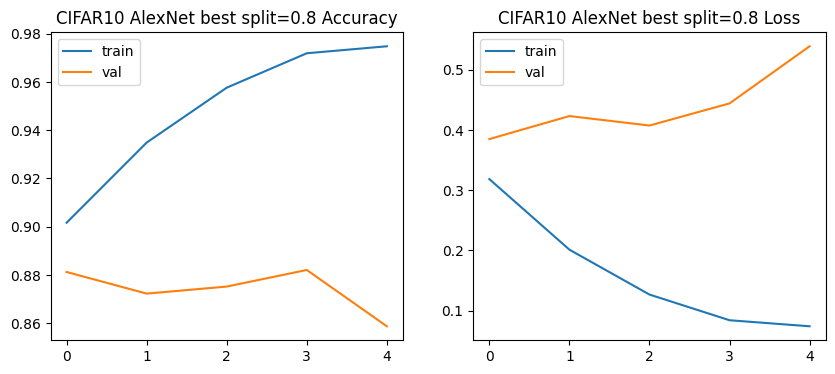

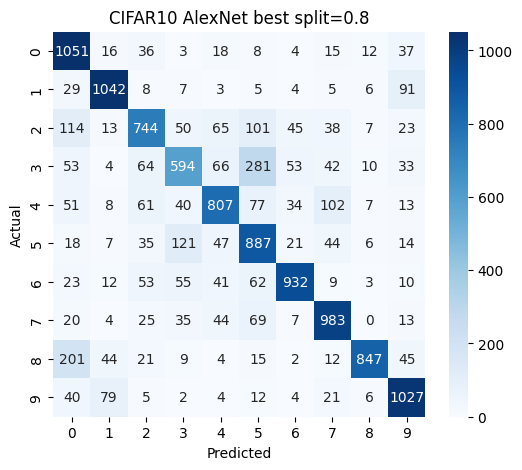

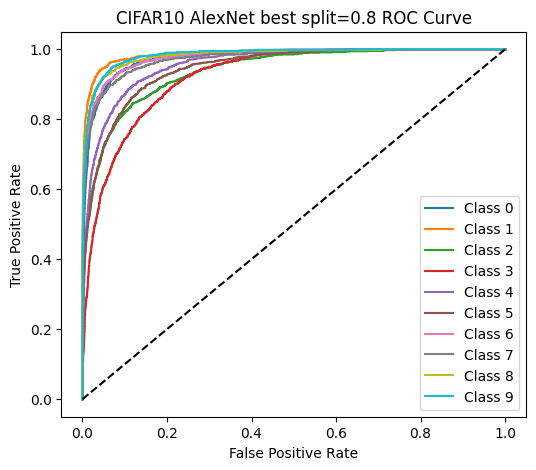

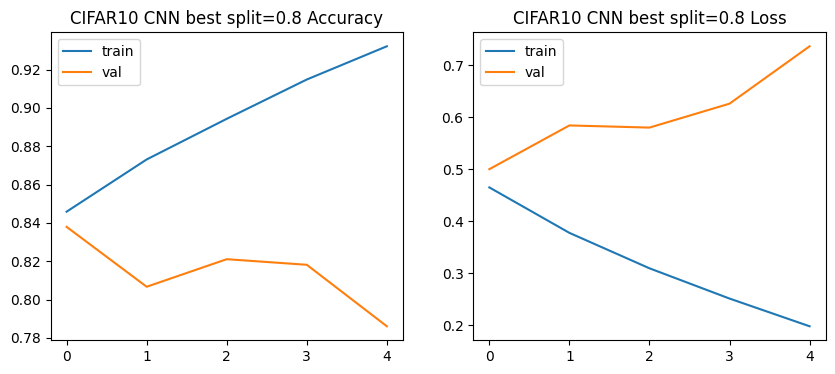

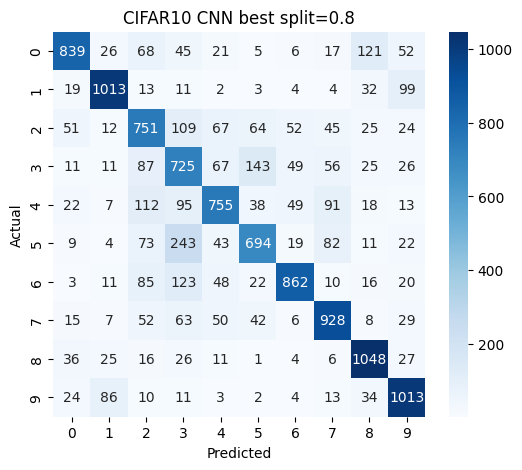

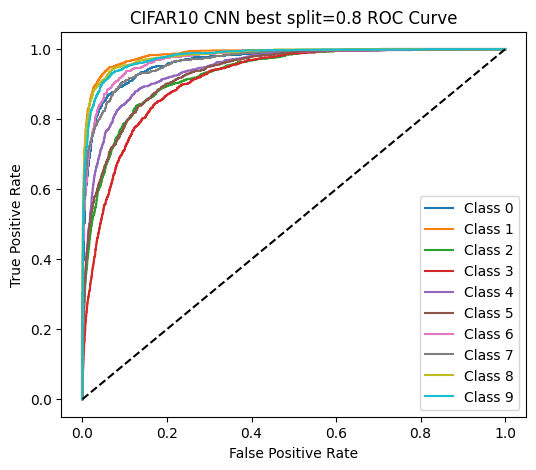

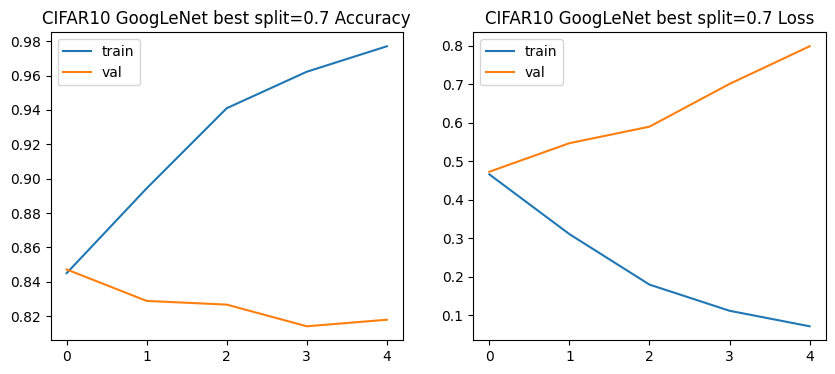

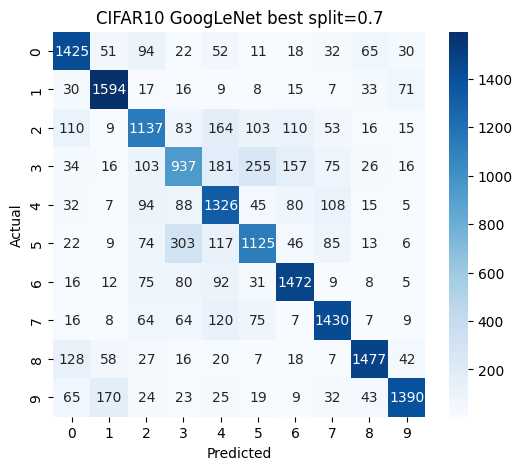

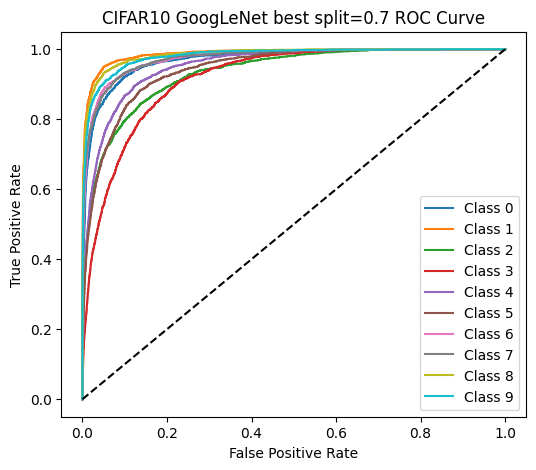

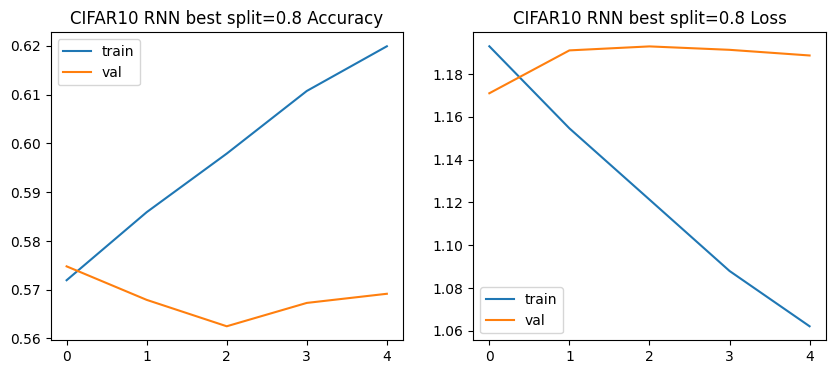

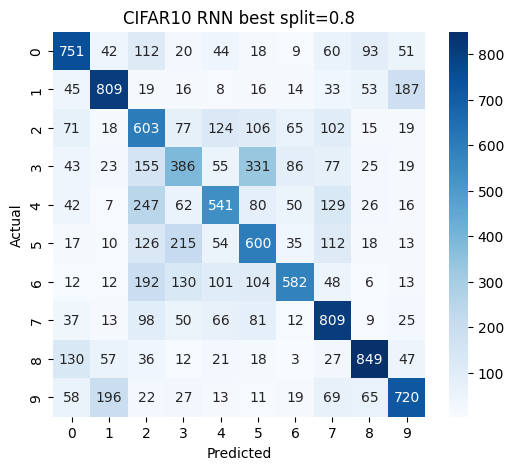

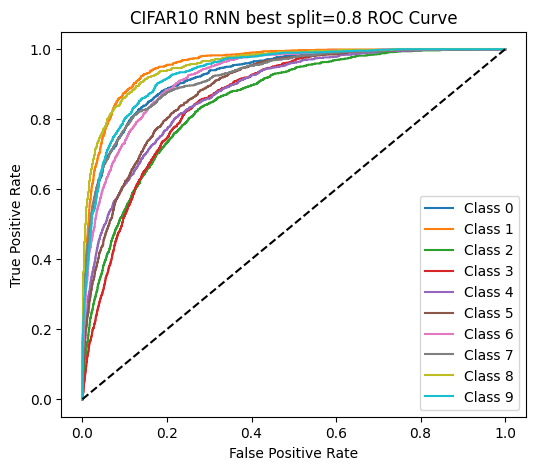

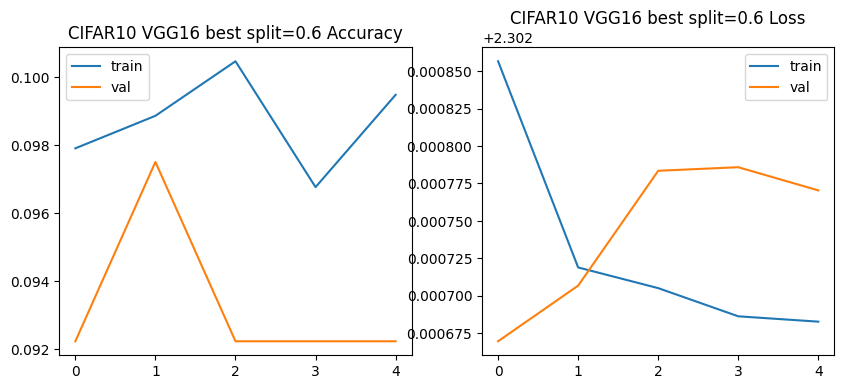

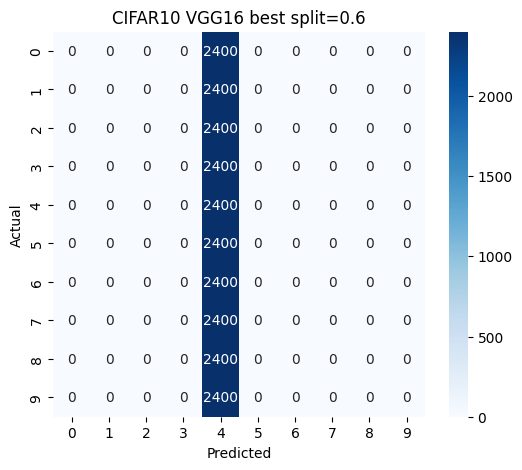

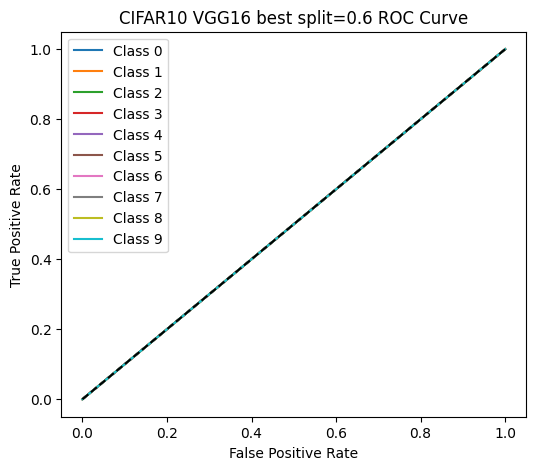

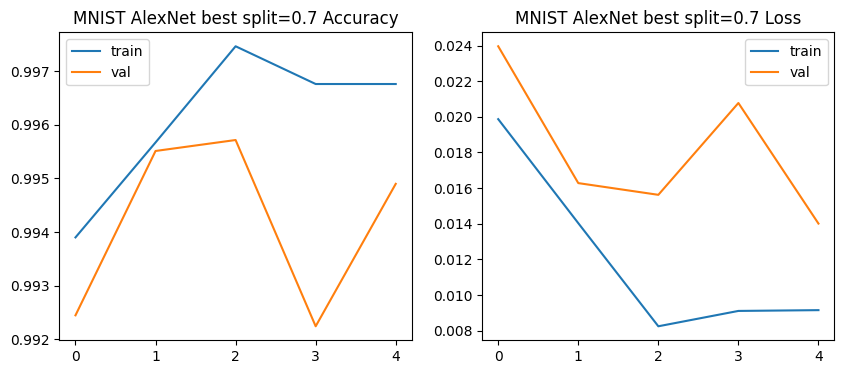

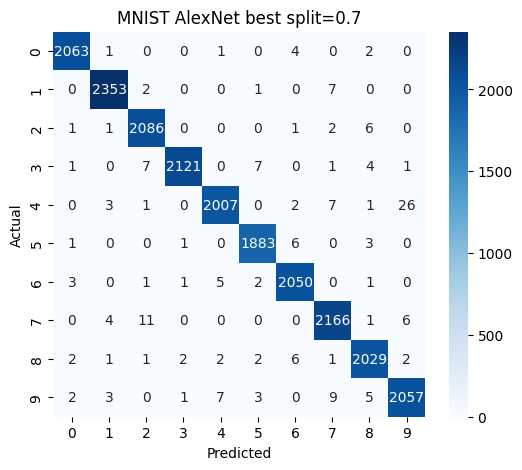

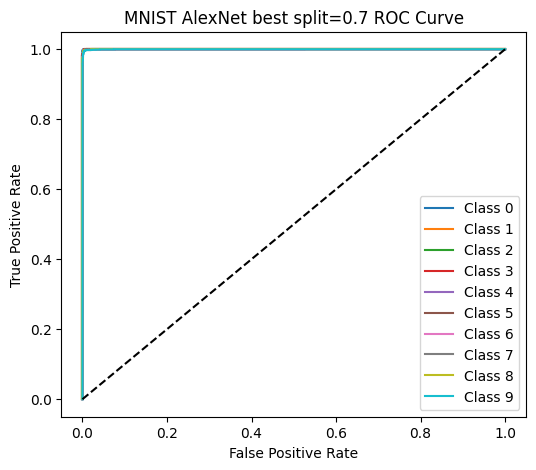

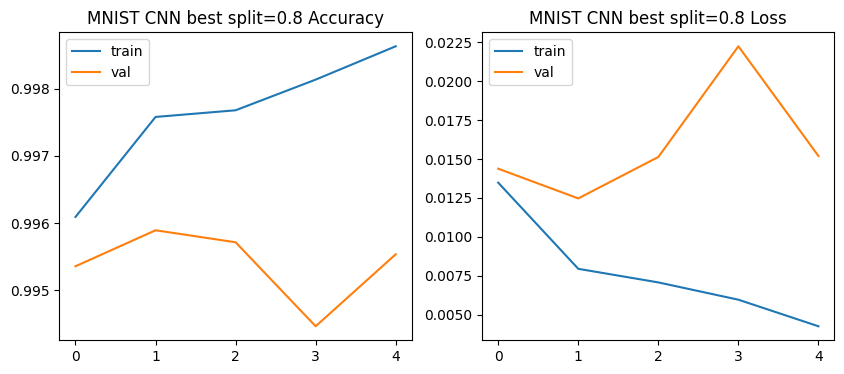

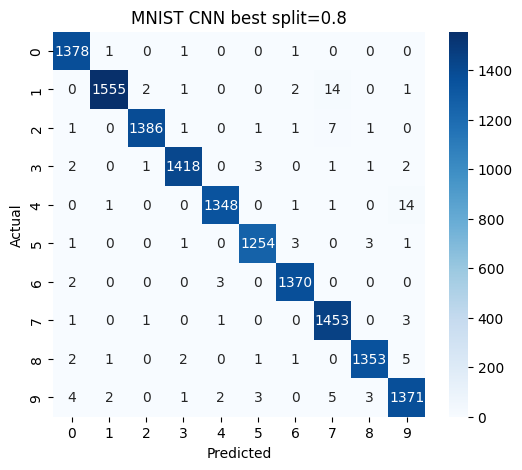

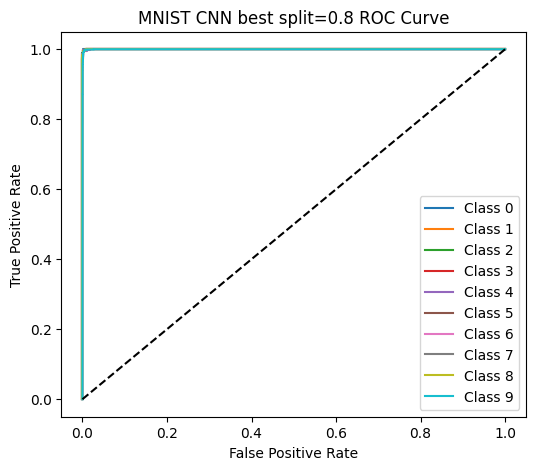

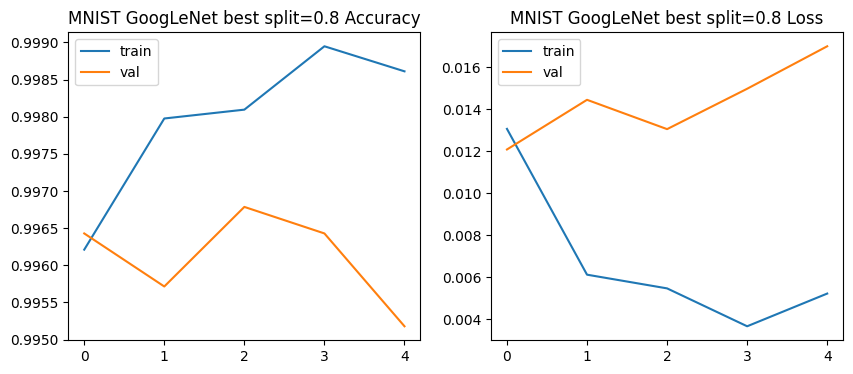

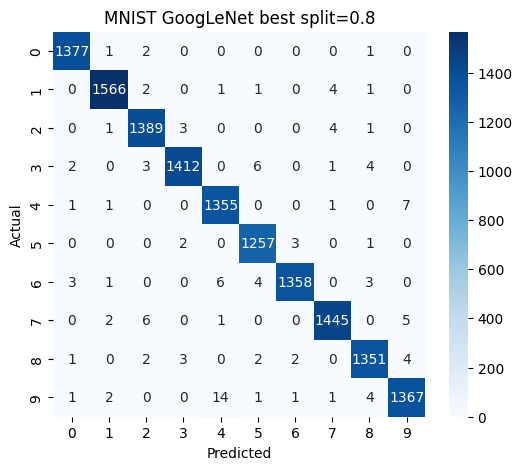

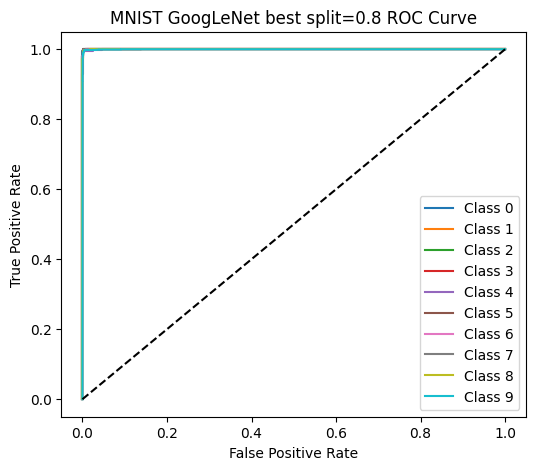

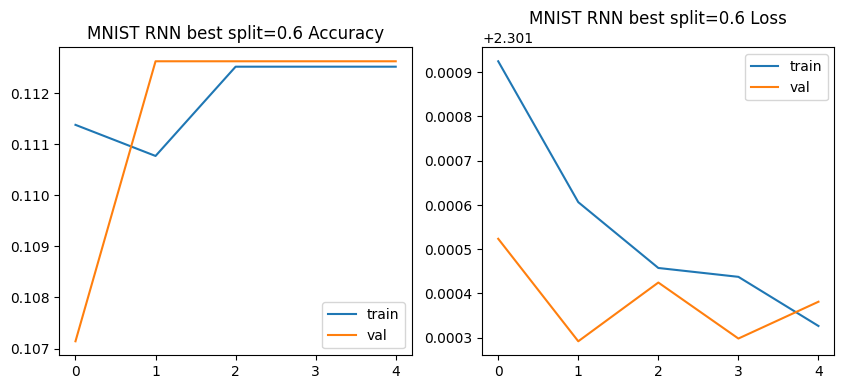

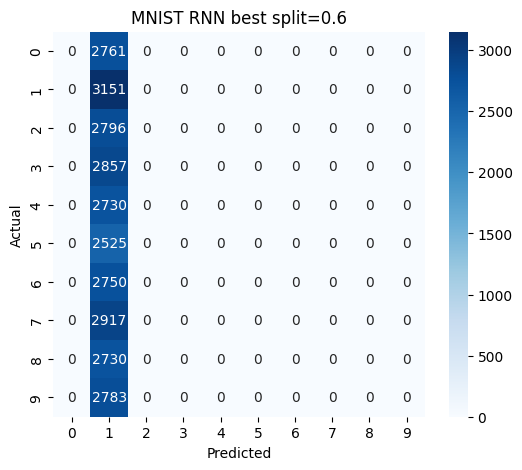

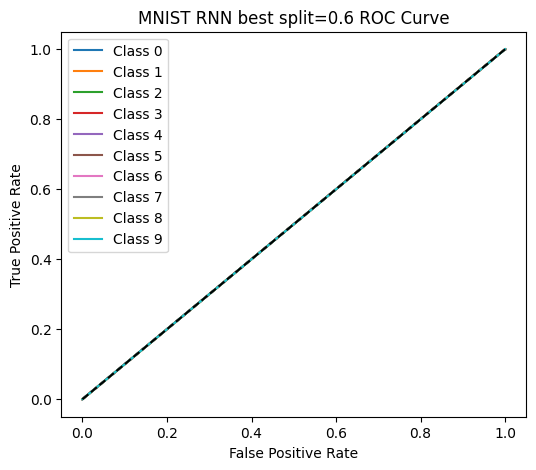

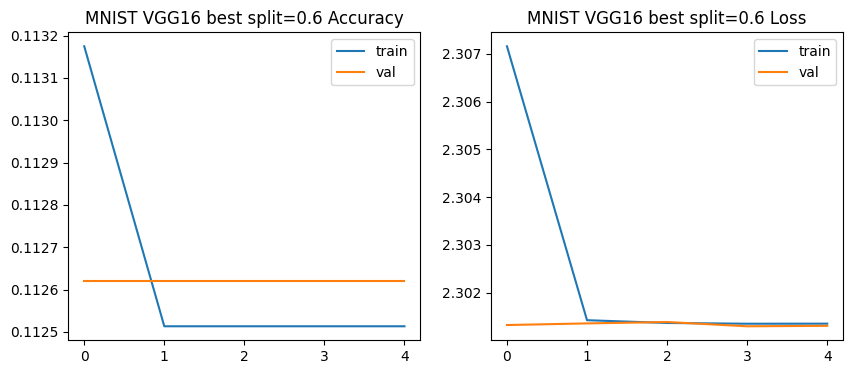

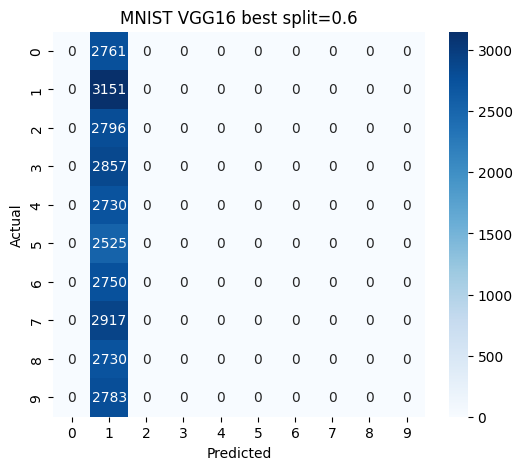

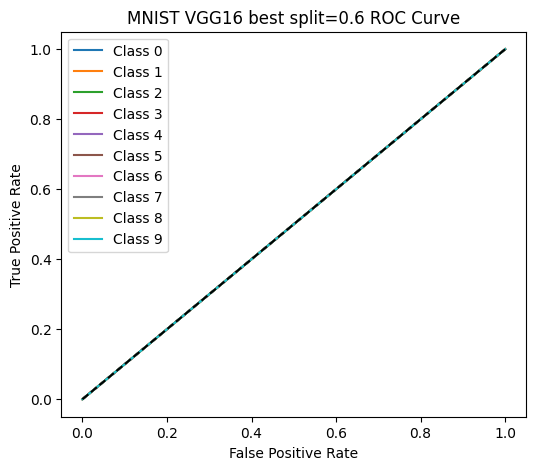

In [13]:
for idx, row in best_cases.iterrows():
    hist = row['History']
    y_true = row['Y_true']
    y_pred = row['Y_pred']
    plot_history(hist,f"{row['Dataset']} {row['Model']} best split={row['Split']}")
    pred_labels = np.argmax(y_pred,axis=1)
    plot_cm(y_true,pred_labels,f"{row['Dataset']} {row['Model']} best split={row['Split']}")
    plot_roc(to_categorical(y_true,10), y_pred, f"{row['Dataset']} {row['Model']} best split={row['Split']}")

### Save best case comparison

In [14]:
best_cases.drop(columns=['History','Y_true','Y_pred'], inplace=True)
best_cases.to_csv("DeepLearning_BestCase_Comparison.csv",index=False)
print("Saved DeepLearning_BestCase_Comparison.csv ✅")
display(best_cases)

Saved DeepLearning_BestCase_Comparison.csv ✅


,Dataset,Model,Split,Accuracy,Precision,Recall,F1,AUC
27,CIFAR10,AlexNet,0.8,0.742833,0.751883,0.742833,0.741455,0.964828
25,CIFAR10,CNN,0.8,0.719000,0.724858,0.719000,0.719475,0.957554
23,CIFAR10,GoogLeNet,0.7,0.739611,0.740408,0.739611,0.738701,0.962030
29,CIFAR10,RNN,0.8,0.554167,0.563124,0.554167,0.554773,0.909461
16,CIFAR10,VGG16,0.6,0.100000,0.010000,0.100000,0.018182,0.500000
7,MNIST,AlexNet,0.7,0.991190,0.991201,0.991190,0.991189,0.999915
10,MNIST,CNN,0.8,0.991857,0.991892,0.991857,0.991861,0.999947
13,MNIST,GoogLeNet,0.8,0.991214,0.991226,0.991214,0.991213,0.999911
4,MNIST,RNN,0.6,0.112536,0.012664,0.112536,0.022767,0.500073
1,MNIST,VGG16,0.6,0.112536,0.012664,0.112536,0.022767,0.500000
